<a href="https://colab.research.google.com/github/Running-Machine-ML23-2/problem_1/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle

SAMPLES_PER_SITE = 90  # We want 10 samples per site
TOTAL_SITES = 95  # Total number of sites
URL_PER_SITE = 10  # The number of URLs crawled per site

# Load the pickle file
print("Loading datafile...")
with open("/content/drive/MyDrive/Colab Notebooks/mon_standard.pkl", 'rb') as fi:  # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1_mon = []  # Array to store instances (timestamps)
X2_mon = []  # Array to store instances (direction*size)
y = []  # Array to store the site of each instance

# Differentiate instances and sites, and store them in the respective X and y arrays
for i in range(TOTAL_SITES):
    label = i
    sample_count = 0  # Add a counter to keep track of the number of samples for each label
    for j in range(URL_PER_SITE):
        if sample_count >= SAMPLES_PER_SITE:  # If we already have enough samples for this label, skip
            break
        samples = data[i * URL_PER_SITE + j]
        for sample in samples:
            if sample_count >= SAMPLES_PER_SITE:  # If we already have enough samples for this label, skip
                break
            size_seq = []
            time_seq = []
            for c in sample:
                dr = 1 if c > 0 else -1
                time_seq.append(abs(c))
                size_seq.append(dr * 512)
            X1_mon.append(time_seq)
            X2_mon.append(size_seq)
            y.append(label)
            sample_count += 1  # Increment the counter

print(f'Total samples (monitored): {len(y)}')




Loading datafile...
Total samples (monitored): 8550


In [ ]:
# Load data from the new file
with open('/content/drive/MyDrive/Colab Notebooks/sub_data/unmon_data_sub1.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x_unmon = pickle.load(f)

for i in range(3000):
  size_seq = []
  time_seq = []
  for c in x_unmon[i]:
    dr = 1 if c > 0 else -1
    time_seq.append(abs(c))
    size_seq.append(dr * 512)
  X1_mon.append(time_seq)
  X2_mon.append(size_seq)

# Append -1 to y for each instance in X1_mon
y = y + [-1] * 3000
print(len(X1_mon))
print(f'Total samples (combined): {len(y)}')

11550
Total samples (combined): 11550


In [ ]:
import numpy as np
outgoing_packets_fraction = []  # Array to store the outgoing packets fraction for unmonitored data
std_outgoing_packet_ordering = []  # Array to store the standard deviation of outgoing packet ordering for unmonitored data

for i in range(len(X1_mon)):
    outgoing_packets = 0
    packet_ordering = []
    for j in range(len(X1_mon[i])):
        if X2_mon[i][j] > 0:
            outgoing_packets += 1
            packet_ordering.append(X1_mon[i][j])
    outgoing_packets_fraction.append(outgoing_packets / len(X1_mon[i]))
    std_outgoing_packet_ordering.append(np.std(packet_ordering))

In [ ]:
MAX_SEQUENCE_LENGTH = 100  # 시퀀스의 최대 길이

def pad_sequence(seq, max_length):
    if len(seq) < max_length:
        seq += [0] * (max_length - len(seq))  # 패딩
    else:
        seq = seq[:max_length]  # 잘라냄
    return seq

def compute_bursts(sequence):
    bursts = []
    current_burst = sequence[0]

    for size in sequence[1:]:
        if np.sign(size) == np.sign(current_burst):
            current_burst += size
        else:
            bursts.append(current_burst)
            current_burst = size
    bursts.append(current_burst)
    return bursts

X2_all = X2_mon

X1_all= X1_mon

X2_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X2_all]
X1_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X1_all]

X_mon_bursts = [pad_sequence(compute_bursts(x), MAX_SEQUENCE_LENGTH) for x in X2_mon]

X_mon_cumsum = [pad_sequence(np.cumsum(x).tolist(), MAX_SEQUENCE_LENGTH) for x in X2_mon]


num_packets = [sum(1 for size in instance_sizes if size < 0) for instance_sizes in X2_mon]
X_CAT1 = num_packets
X_CAT2 = outgoing_packets_fraction
X_CAT4 = std_outgoing_packet_ordering

X_CAT1 = np.array(X_CAT1).reshape(-1, 1)
X_CAT2 = np.array(X_CAT2).reshape(-1, 1)
X_CAT4 = np.array(X_CAT4).reshape(-1, 1)


In [ ]:
# KNN 코드
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations
from sklearn.model_selection import train_test_split

# 피처 목록
features = [X2_all, X1_all, X_mon_bursts, X_mon_cumsum, X_CAT1, X_CAT2, X_CAT4]
feature_names = ['X2_all', 'X1_all', 'X_mon_bursts', 'X_mon_cumsum', 'X_CAT1', 'X_CAT2', 'X_CAT4']  # 피처 이름

# 결과를 저장할 딕셔너리
results = {}

# 가능한 모든 조합에 대해
for r in range(1, len(features) + 1):
    for subset_indices in combinations(range(len(features)), r):  # 인덱스로 조합 생성
        subset = [features[i] for i in subset_indices]  # 선택된 피처 리스트
        subset_names = [feature_names[i] for i in subset_indices]  # 선택된 피처 이름 리스트

        # 피처를 합칩니다
        X = np.concatenate([np.array(feature) for feature in subset], axis=1)
        # 훈련 데이터와 테스트 데이터 나누기
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 모델 초기화
        knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

        # 모델 학습
        knn_classifier.fit(X_train, y_train)

        # 예측
        y_pred = knn_classifier.predict(X_test)

        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)

        # 결과 저장
        results[tuple(subset_names)] = accuracy  # 키를 튜플로 변환

# 결과 출력
for subset, accuracy in results.items():
    print("Features: ", subset)
    print("Accuracy: {:.3f}".format(accuracy))

Features:  ('X2_all',)
Accuracy: 0.783
Features:  ('X1_all',)
Accuracy: 0.348
Features:  ('X_mon_bursts',)
Accuracy: 0.367
Features:  ('X_mon_cumsum',)
Accuracy: 0.697
Features:  ('X_CAT1',)
Accuracy: 0.246
Features:  ('X_CAT2',)
Accuracy: 0.195
Features:  ('X_CAT4',)
Accuracy: 0.198
Features:  ('X2_all', 'X1_all')
Accuracy: 0.782
Features:  ('X2_all', 'X_mon_bursts')
Accuracy: 0.368
Features:  ('X2_all', 'X_mon_cumsum')
Accuracy: 0.715
Features:  ('X2_all', 'X_CAT1')
Accuracy: 0.823
Features:  ('X2_all', 'X_CAT2')
Accuracy: 0.813
Features:  ('X2_all', 'X_CAT4')
Accuracy: 0.793
Features:  ('X1_all', 'X_mon_bursts')
Accuracy: 0.367
Features:  ('X1_all', 'X_mon_cumsum')
Accuracy: 0.700
Features:  ('X1_all', 'X_CAT1')
Accuracy: 0.342
Features:  ('X1_all', 'X_CAT2')
Accuracy: 0.348
Features:  ('X1_all', 'X_CAT4')
Accuracy: 0.358
Features:  ('X_mon_bursts', 'X_mon_cumsum')
Accuracy: 0.497
Features:  ('X_mon_bursts', 'X_CAT1')
Accuracy: 0.371
Features:  ('X_mon_bursts', 'X_CAT2')
Accuracy: 0

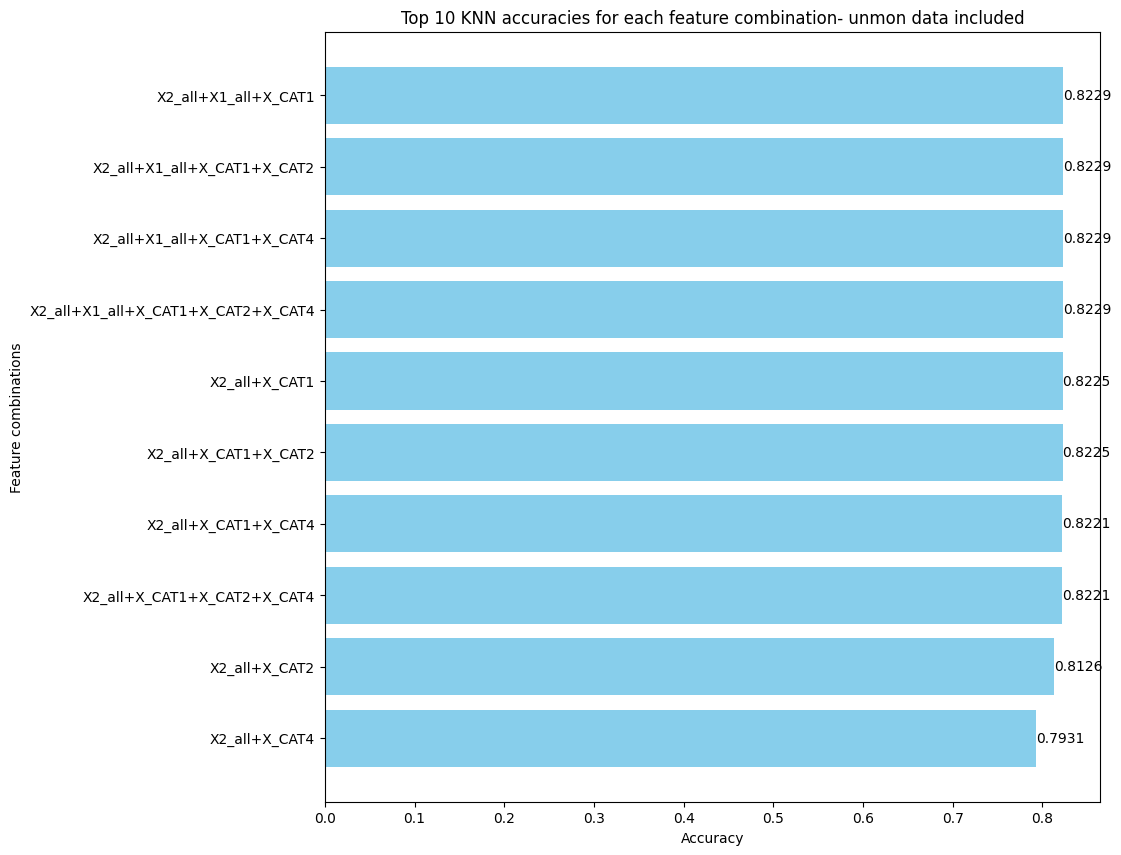

In [ ]:
import matplotlib.pyplot as plt

# 결과를 정확도에 따라 내림차순으로 정렬
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

# 상위 10개만 선택
sorted_results = sorted_results[:10]

# 피처 조합과 정확도를 분리
feature_combinations, accuracies = zip(*sorted_results)

# 피처 조합을 문자열로 변환
feature_combinations = ['+'.join(features) for features in feature_combinations]

# 막대 그래프 생성
plt.figure(figsize=(10, 10))
bars = plt.barh(feature_combinations, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Feature combinations')
plt.title('Top 10 KNN accuracies for each feature combination- unmon data included')

# 결과값(result)을 막대 옆에 출력
for bar, result in zip(bars, sorted_results):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{result[1]:.4f}', va='center', ha='left')

plt.gca().invert_yaxis()  # y축을 내림차순으로 정렬
plt.show()
